<a href="https://colab.research.google.com/github/hellocybernetics/Pyro_tutorials/blob/master/tutorials/03_advanced/Variational_Auto_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q --upgrade tf-nightly-gpu-2.0-preview

    100% |████████████████████████████████| 337.5MB 64kB/s 
    100% |████████████████████████████████| 3.0MB 8.4MB/s 
    100% |████████████████████████████████| 358kB 11.2MB/s 
    100% |████████████████████████████████| 61kB 21.2MB/s 


In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

tfk = tf.keras

In [3]:
(x_train, y_train),(x_test, y_test) = tfk.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(-1, 1, 28, 28)
x_test = x_test.reshape(-1, 1, 28, 28)

x_train_ = tf.convert_to_tensor(x_train, dtype=tf.float32)
x_test_ = tf.convert_to_tensor(x_test, dtype=tf.float32)

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
image_size = 784
num_epochs = 32
batch_size = 64
learning_rate = 1e-3
base_depth = 32
latent_size = 16

### experiment of encoder and decoder
We start to make encoder which embed an image whose shape of$(1, 28, 28)$ to latent space whose shape of $(32)$.
$$
{\rm encoder}: \mathcal R^{1\times28\times 28} \rightarrow \mathcal R^{32} 
$$

Then, we prepare a decoder for translation latent space to a image.
$$
{\rm decoder}: \mathcal R^{16} \rightarrow \mathcal R^{1\times28\times 28} 
$$
Why does decoder receive $\mathcal R^{16}$ (why not $\mathcal R^{32}$ ) ? Because latent space $\mathcal R^{32}$ is devided two latent space, $\mu \in \mathcal R^{16}$ and  $\sigma \in \mathcal R^{16}$ which are the parameter of gaussian distribution.

In [41]:
encoder_net = tf.keras.Sequential([
    tf.keras.layers.Conv2D(data_format="channels_first",
        filters=base_depth, kernel_size=3, strides=(2, 2), 
        activation=tf.nn.leaky_relu),
    tf.keras.layers.Conv2D(data_format="channels_first",
        filters=base_depth*2, kernel_size=3, strides=(2, 2), 
        activation=tf.nn.leaky_relu),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(latent_size * 2),
])

y_ = encoder_net(tf.random.normal(shape=[100, 1, 28, 28]))
y_.shape

TensorShape([100, 32])

In [42]:
decoder_net = tf.keras.Sequential([
    tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
    tf.keras.layers.Reshape(target_shape=(32, 7, 7)),
    tf.keras.layers.Conv2DTranspose(data_format="channels_first",
        filters=base_depth*2, kernel_size=3, strides=(2, 2), padding="SAME",
        activation=tf.nn.leaky_relu),
    tf.keras.layers.Conv2DTranspose(data_format="channels_first",
        filters=base_depth, kernel_size=3, strides=(2, 2), padding="SAME",
        activation=tf.nn.leaky_relu),
    tf.keras.layers.Conv2DTranspose(data_format="channels_first",
      filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
])

y_ = decoder_net(tf.random.normal(shape=[100, 16]))
y_.shape

TensorShape([100, 1, 28, 28])

### Variational Auto Encoder

In [0]:
class VAE(tfk.Model):
    def __init__(self):
        super(VAE, self).__init__()
        
        self.encoder_net = tf.keras.Sequential([
            tf.keras.layers.Conv2D(data_format="channels_first",
                filters=base_depth, kernel_size=3, strides=(2, 2), 
                activation=tf.nn.leaky_relu),
            tf.keras.layers.Conv2D(data_format="channels_first",
                filters=base_depth*2, kernel_size=3, strides=(2, 2), 
                activation=tf.nn.leaky_relu),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_size * 2),
        ])

        self.decoder_net = tf.keras.Sequential([
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(32, 7, 7)),
            tf.keras.layers.Conv2DTranspose(
                data_format="channels_first",
                filters=base_depth*2, kernel_size=3, 
                strides=(2, 2), padding="SAME",
                activation=tf.nn.leaky_relu),
            tf.keras.layers.Conv2DTranspose(
                data_format="channels_first",
                filters=base_depth, kernel_size=3, 
                strides=(2, 2), padding="SAME",
                activation=tf.nn.leaky_relu),
            tf.keras.layers.Conv2DTranspose(data_format="channels_first",
              filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
        ])

    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, latent_size))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder_net(x), 
                                num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs

        return logits

In [0]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)
 
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
 
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def train(model, x):

    with tf.device("/gpu:0"):
        with tf.GradientTape() as tape:
            loss = compute_loss(model, x)
        grad = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grad, model.variables))
    
    return grad, loss

In [0]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices(x_train_)
    .shuffle(10000)
    .batch(batch_size)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(x_test_)
    .shuffle(10000)
    .batch(1000)
)

model = VAE()

In [47]:
for epoch in range(1, num_epochs + 1):
    for train_x in train_dataset:
        gradients, loss = train(model, train_x)
 
    if epoch % 1 == 0:
        loss = tf.metrics.Mean()
        for test_x in test_dataset:
            loss(compute_loss(model, test_x))
        elbo = -loss.result()
    print('Epoch: {}, Test set ELBO: {}, '
          .format(epoch, elbo))

Epoch: 1, Test set ELBO: -112.0238037109375, 
Epoch: 2, Test set ELBO: -107.53266906738281, 
Epoch: 3, Test set ELBO: -105.5594253540039, 
Epoch: 4, Test set ELBO: -104.45086669921875, 
Epoch: 5, Test set ELBO: -103.3265380859375, 
Epoch: 6, Test set ELBO: -102.97819519042969, 
Epoch: 7, Test set ELBO: -102.10676574707031, 
Epoch: 8, Test set ELBO: -101.55846405029297, 
Epoch: 9, Test set ELBO: -101.42646789550781, 
Epoch: 10, Test set ELBO: -101.27531433105469, 
Epoch: 11, Test set ELBO: -100.62117004394531, 
Epoch: 12, Test set ELBO: -100.23733520507812, 
Epoch: 13, Test set ELBO: -100.12088012695312, 
Epoch: 14, Test set ELBO: -99.79299926757812, 
Epoch: 15, Test set ELBO: -99.71162414550781, 
Epoch: 16, Test set ELBO: -99.8812255859375, 
Epoch: 17, Test set ELBO: -99.44962310791016, 
Epoch: 18, Test set ELBO: -99.44953918457031, 
Epoch: 19, Test set ELBO: -99.37784576416016, 
Epoch: 20, Test set ELBO: -99.30270385742188, 
Epoch: 21, Test set ELBO: -99.04085540771484, 
Epoch: 22, Te

### sampling

In [0]:
sample_image = model.sample()

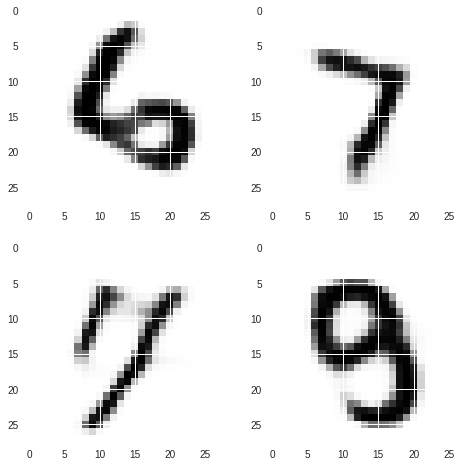

In [49]:
plt.figure(figsize=(8, 8))
for i in range(1, 4 + 1):
    plt.subplot(2, 2, i)
    plt.imshow(sample_image[i].numpy().reshape(28,28))

### latent space

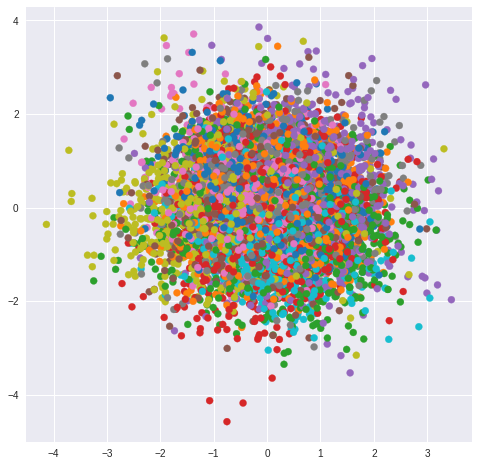

In [50]:
mu, logvar = model.encode(x_train_[:10000])
z = model.reparameterize(mu, logvar)

plt.figure(figsize=(8, 8))
plt.scatter(z[:, 0], z[:, 1], c=y_train[:10000], cmap="tab10")

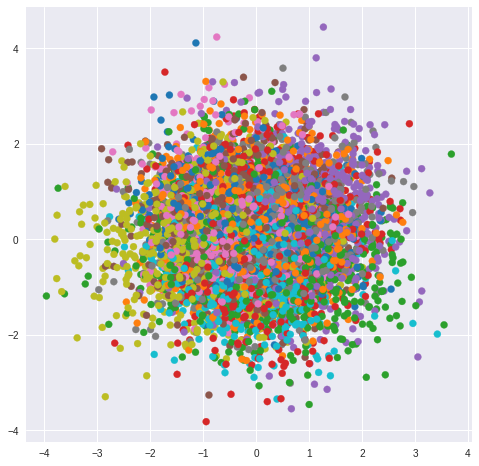

In [51]:
mu, logvar = model.encode(x_test_[:10000])
z = model.reparameterize(mu, logvar)

plt.figure(figsize=(8, 8))
plt.scatter(z[:, 0], z[:, 1], c=y_test[:10000], cmap="tab10")